# 데이터 마이닝 시험
- 담당 교수: 송민석
- 시험 일시: 20201.10.18 (월) 10:00 ~ 12:00 (2시간)

참고)
- 문제는 Prbelm X.X로 표기되어 있음
- 그래프 plotting의 경우 완벽하게 같은 그래프를 그릴 필요는 없음
- 소문제 하나당 1점으로 총 22점 (보너스 문제도 소문제 하나당 1점)

# Import modules
아래 주어진 모듈 이외에 추가로 필요한 모듈들이 있다면, 추가로 임포트하여 사용 가능함

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.manifold import TSNE
from pm4py.objects.log.importer.xes import importer
from pm4py.objects.log.util import interval_lifecycle
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.algo.filtering.log.timestamp import timestamp_filter
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Problem 1: 전처리

## 데이터 소개
X variables
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

y variable
- HeartDisease: output class [1: heart disease, 0: Normal]

##### 데이터 파일 디렉토리에 따라 코드 변경하여 임포트 가능

In [2]:
heart_df = pd.read_csv("heart.csv")
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289,0.0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160.0,180,0.0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130.0,283,0.0,ST,98,N,0.0,Up,0
3,48,F,ASY,138.0,214,0.0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150.0,195,NaN,Normal,122,N,0.0,Up,0


In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       910 non-null    float64
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       914 non-null    float64
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 86.2+ KB


## 결측치 처리

### Problem 1.1: 각 컬럼별 결측치 수를 bar graph로 시각화하시오¶

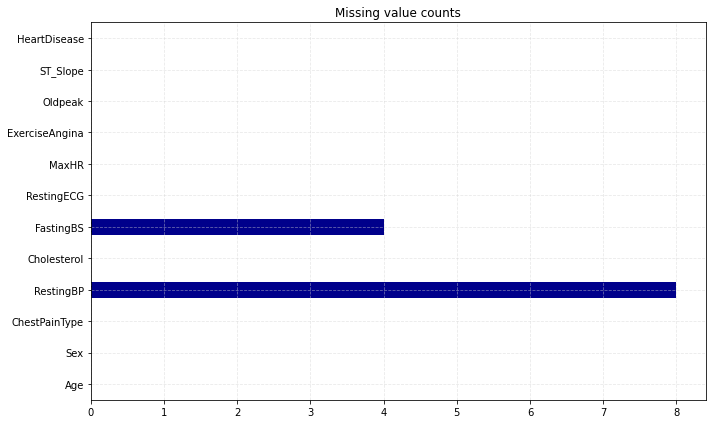

In [4]:
## code ##

plt.title("Missing value counts")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

### Probelm 1.2: 결측치를 처리하여 heart_df에 저장하시오
- FastingBS이 결측된 경우 데이터를 제거 (행 drop)
- RestingBP이 결측된 경우 평균값을 넣어 처리

In [5]:
## code

heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             914 non-null    int64  
 1   Sex             914 non-null    object 
 2   ChestPainType   914 non-null    object 
 3   RestingBP       914 non-null    float64
 4   Cholesterol     914 non-null    int64  
 5   FastingBS       914 non-null    float64
 6   RestingECG      914 non-null    object 
 7   MaxHR           914 non-null    int64  
 8   ExerciseAngina  914 non-null    object 
 9   Oldpeak         914 non-null    float64
 10  ST_Slope        914 non-null    object 
 11  HeartDisease    914 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 92.8+ KB


## 이상치 처리

### Problem 1.3: ChestPainType 칼럼에 이상치가 없는지 확인하시오
- 각 값을 가진 데이터가 몇 개나 되는지 확인하여 이상치 찾기 (꼭 이 방법이 아니더라도 (즉 아래와 같은 출력결과를 보이는 방법이 아니더라도) 다양한 방법으로 이상치를 확인하고, 어떻게 그렇게 판단할 수 있는지 설명하는 것으로 대체 가능)

In [6]:
## code

ASY    493
NAP    200
ATA    173
TA      46
.        2
Name: ChestPainType, dtype: int64

=> '.'이 이상치로 판단됨

### Problem 1.4: ChestPainType 칼럼의 이상치를 처리하여 heart_df에 저장하시오
- ChestPainType 값이 '.'인 데이터 제거 (행 drop)

In [7]:
## code

heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             912 non-null    int64  
 1   Sex             912 non-null    object 
 2   ChestPainType   912 non-null    object 
 3   RestingBP       912 non-null    float64
 4   Cholesterol     912 non-null    int64  
 5   FastingBS       912 non-null    float64
 6   RestingECG      912 non-null    object 
 7   MaxHR           912 non-null    int64  
 8   ExerciseAngina  912 non-null    object 
 9   Oldpeak         912 non-null    float64
 10  ST_Slope        912 non-null    object 
 11  HeartDisease    912 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 92.6+ KB


## Outlier 처리
- RestingBP, Cholesterol, MaxHR, Oldpeak 칼럼에 대해서만 수행

### Problem 1.5: Boxplot 을 이용하여 칼럼별 분포를 파악해보시오

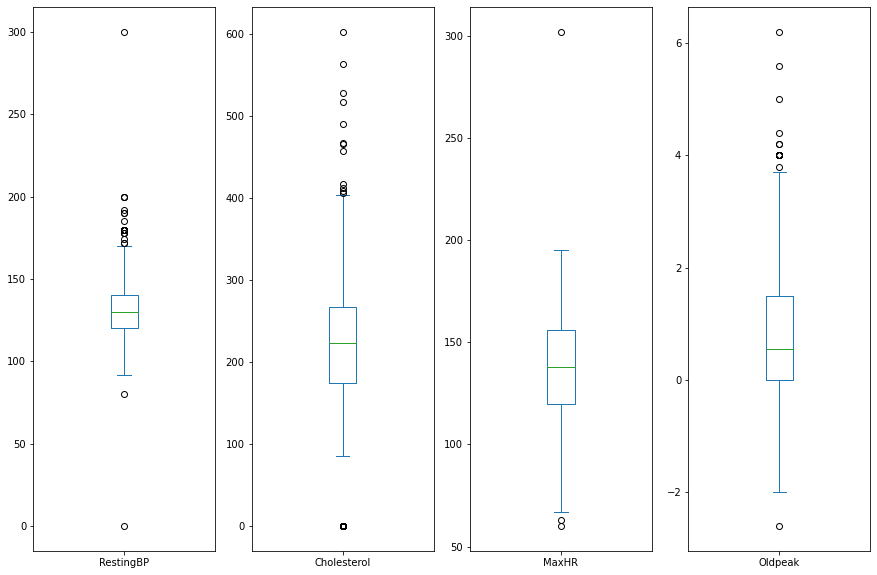

In [8]:
## code

plt.show()

### Problem 1.6: 각 칼럼을 표준점수(Z-score)로 변환한 후 $\pm{3} std$를 벗어나는 경우 제거하여 heart_df에 저장하시오
- RestingBP, Cholesterol, MaxHR, Oldpeak 칼럼 중 하나라도 $\pm{3} std$를 벗어나는 경우 해당 데이터 제거 (행 drop)

In [11]:
## code

heart_df[['RestingBP','Cholesterol','MaxHR','Oldpeak']].describe()

,RestingBP,Cholesterol,MaxHR,Oldpeak
count,893.000000,893.000000,893.000000,893.000000
mean,132.072917,198.377380,136.790594,0.859462
std,17.051832,107.097352,25.453771,1.007668
min,80.000000,0.000000,60.000000,-2.000000
25%,120.000000,175.000000,120.000000,0.000000
50%,130.000000,223.000000,138.000000,0.500000
75%,140.000000,266.000000,156.000000,1.500000
max,185.000000,518.000000,194.000000,4.000000


## Categorical 변수 처리
- Sex, ChestPainType, FastingBS, RestingECG, ExerciseAngina, ST_Slope 칼럼들을 one-hot encoding

### Problem 1.7: 변수들을 drop_first = True로 one-hot encoding하시오

In [18]:
## code

heart_df.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1.0,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140.0,289,172,0.0,0,1,1,0,0,0,1,0,0,0,1
1,49,160.0,180,156,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,130.0,283,98,0.0,0,1,1,0,0,0,0,1,0,0,1
3,48,138.0,214,108,1.5,1,0,0,0,0,0,1,0,1,1,0
5,39,120.0,339,170,0.0,0,1,0,1,0,0,1,0,0,0,1


## Train set, test set 분리 및 scaling

### Probelem 1.8: 데이터를 train : test = 7 : 3 비율로 분리하시오
- random_state = 1

In [32]:
X = ## code
y = ## code
train_X, test_X, train_y, test_y = ## code

### Problem 1.9: StandardScaler를 이용하여 scaling 하시오

In [34]:
## code
train_X_norm = ## code
test_X_norm = ## code

# Problem 2: 분류 모델 학습 및 평가

## Grid search을 이용한 모델 학습
- Grid search를 활용하여 logistic regression, deicision tree, random forest 모델의 최적 모델 찾기
- k-fold cross validation의 k 값은 5로 수행

### 모델별 테스트 할 파라미터 조합

In [27]:
# Logistic regression용 하이퍼파라미터
logit_param_grid = {  
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'C': [10, 1, 0.1, 0.01],
    'penalty': ["l2"]
}

# Decision tree용 하이퍼파라미터
tree_param_grid = {  
    'max_depth': [3, 6, 9, 12, 15],   
    'min_samples_split': [5, 10, 15, 20],   
    'min_impurity_decrease': [0.0001, 0.001, 0.005, 0.01],   
}

# Random forest용 하이퍼파라미터
rf_param_grid = {  
    'n_estimators': [10, 50, 100, 250, 500],
    'max_depth': [3, 6, 9, 12, 15],
    'min_samples_split': [5, 10, 15, 20],   
    'min_impurity_decrease': [0.0001, 0.001, 0.005, 0.01]
}  

### Problem 2.1: Logitic regression 최적 모델 찾기

In [28]:
logit_gridSearch = ## code
print('Logit best hyperparameters: ', logit_gridSearch.best_params_)
logit_best = ## best estimator 저장

Logit best hyperparameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


### Problem 2.2: Decision tree 최적 모델 찾기

In [30]:
tree_gridSearch = ## code
print('Tree best hyperparameters: ', tree_gridSearch.best_params_)
tree_best = ## best estimator 저장

Tree best hyperparameters:  {'max_depth': 3, 'min_impurity_decrease': 0.0001, 'min_samples_split': 5}


### Problem 2.3: Random forest 최적 모델 찾기

In [31]:
rf_gridSearch = ## code
print('RF best hyperparameters: ', rf_gridSearch.best_params_)
rf_best = ## best estimator 저장

RF best hyperparameters:  {'max_depth': 9, 'min_impurity_decrease': 0.001, 'min_samples_split': 15, 'n_estimators': 50}


## 모델 평가
- confusion matrix, accuracy, precision, recall을 이용하여 모델을 평가
- 평가 시 Positive label = 1로 하여 계산

### Problem 2.4: test set을 활용하여 Probelm 2.1에서 도출한 logistic regression best 모델을 평가하시오

In [51]:
m = # confusion matrix
a = # accuracy
p = # precision
r = # recall
print(f"confusion matrix: \n{m}\n")
print(f'Accuracy: {a:.3f}')
print(f'Precision: {p:.3f}')
print(f'Recall: {r:.3f}')

confusion matrix: 
[[136  14]
 [ 17 101]]

Accuracy: 0.884
Precision: 0.889
Recall: 0.907


### Problem 2.5: test set을 활용하여 Probelm 2.2에서 도출한 decision tree best 모델을 평가하시오

In [52]:
m = # confusion matrix
a = # accuracy
p = # precision
r = # recall
print(f"confusion matrix: \n{m}\n")
print(f'Accuracy: {a:.3f}')
print(f'Precision: {p:.3f}')
print(f'Recall: {r:.3f}')

confusion matrix: 
[[123  27]
 [ 21  97]]

Accuracy: 0.821
Precision: 0.854
Recall: 0.820


### Problem 2.6: test set을 활용하여 Probelm 2.3에서 도출한 random forest best 모델을 평가하시오

In [54]:
m = # confusion matrix
a = # accuracy
p = # precision
r = # recall
print(f"confusion matrix: \n{m}\n")
print(f'Accuracy: {a:.3f}')
print(f'Precision: {p:.3f}')
print(f'Recall: {r:.3f}')

confusion matrix: 
[[140  10]
 [ 23  95]]

Accuracy: 0.877
Precision: 0.859
Recall: 0.933


### Problem 2.7: 3가지 best model 중 accuracy가 가장 높은 모델에 대해 ROC를 그리고 AUC 값을 구하시오

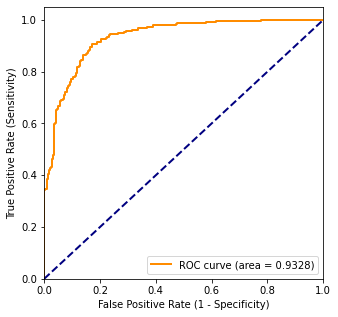

In [53]:
fpr, tpr, threshold = ## code
roc_auc = ## code
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

# Problem 3: T-SNE

## T-SNE 학습

### Problem 3.1: 아래 주어진 X를 이용하여 TSNE를 학습하고 학습 결과를 출력하시오
- TSNE 객체 선언 시 random_state=1로 함

In [56]:
X = heart_df.drop(columns=['HeartDisease'])

tsne_result = ## code
tsne_result

array([[ -4.026969 , -15.311814 ],
       [  4.915294 ,  29.199467 ],
       [ 13.977338 , -19.416468 ],
       ...,
       [ 17.108572 ,  39.013416 ],
       [ -5.2734714,   5.8607407],
       [  1.5833632,  31.313026 ]], dtype=float32)

## T-SNE 결과 시각화

### Problem 3.2: TSNE 결과를 scatter plot으로 시각화 하시오
- label 0: color = "black", alpha = 0.5
- label 1: color = "red", alpha = 0.5

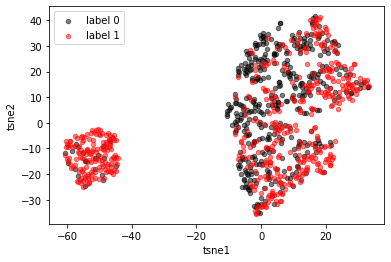

In [76]:
## code

plt.show()

# Problem 4: Process mining

## Data import

In [2]:
log = importer.apply('BPI_Challenge_2012.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

## Log transformation

In [3]:
interval_log = interval_lifecycle.to_interval(log)
len(interval_log)

13087

## Filtering

### Problem 4.1: end activity를 파악하시오
- interval_log를 이용하여 end activity에 뭐가 있고, 각 횟수는 몇이나 되는지 파악

In [4]:
end_activities = ## code
print(end_activities)

{'A_ACTIVATED': 1027, 'A_DECLINED': 7252, 'A_CANCELLED': 1874, 'O_DECLINED': 383, 'A_APPROVED': 300, 'O_ACCEPTED': 252, 'A_REGISTERED': 662, 'O_CANCELLED': 840, 'W_Nabellen offertes': 280, 'W_Completeren aanvraag': 106, 'W_Nabellen incomplete dossiers': 46, 'W_Valideren aanvraag': 9, 'O_SENT_BACK': 46, 'O_SENT': 10}


### Problem 4.2: 출현 횟수가 500이 안 되는 작업으로 끝나는 케이스를 제거하시오

In [6]:
filtered_log = ## code

end_activities_filter.get_end_activities(filtered_log)

{'A_ACTIVATED': 1027,
 'A_DECLINED': 7252,
 'A_CANCELLED': 1874,
 'A_REGISTERED': 662,
 'O_CANCELLED': 840}

In [7]:
len(filtered_log)

11655

### Problem 4.3: 2011-06-01 ~ 2011-12-31 사이의 케이스만 남기고 제거하시오

In [8]:
filtered_log = ## code

print(len(filtered_log))

6300


## Heuristic net

### Problem 4.4: filtered_log를 이용하여 heuristic net을 도출하시오

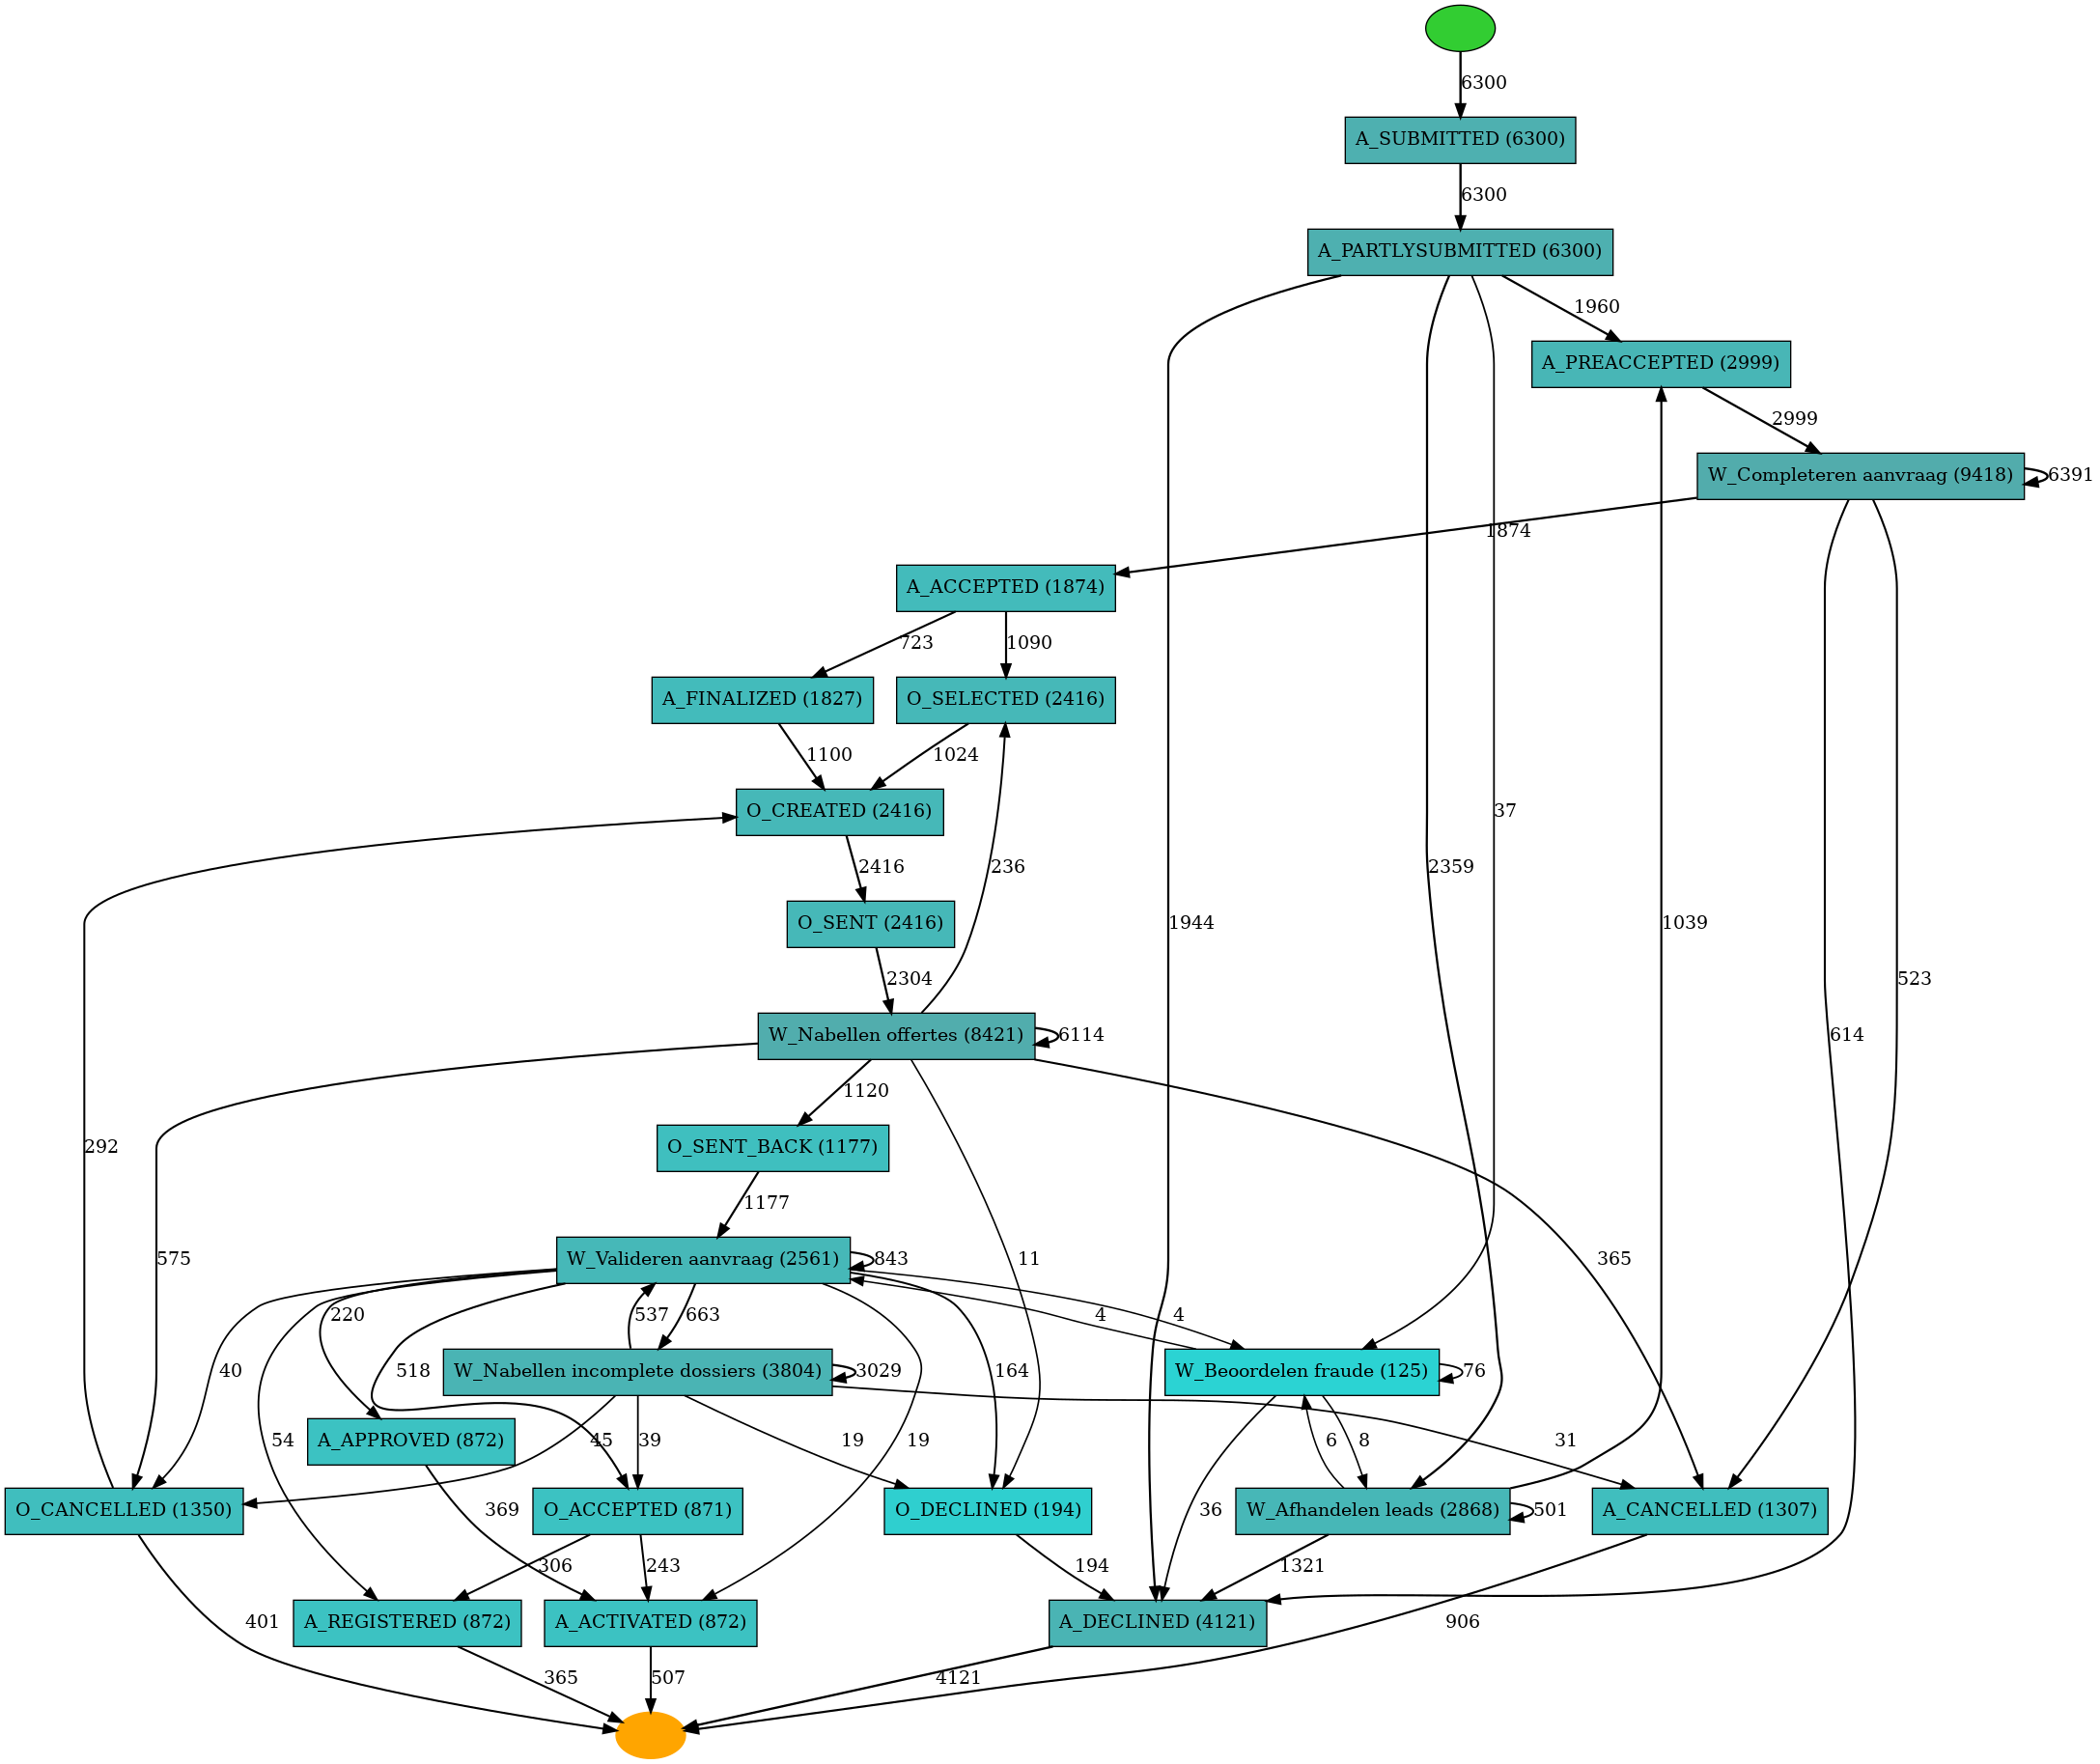

In [9]:
heu_net = ## code
gviz_hn = ## code
hn_visualizer.view(gviz_hn)

# Bonus problem

## Data import

In [10]:
mnames = ['movie_id', 'title', 'genres']
movies_df = pd.read_table('movie.dat', sep='::', header=None, names=mnames)
movies_df

/root/miniconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


## Dataframe transformation

### Problem B.1: genres 컬럼을 가공하여 genres set (유니크한 장르 리스트)을 구하시오

In [21]:
genres = []
## code
print(genres)

['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


### Problem B.2: 각 영화가 속하는 장르를 나타내는 dataframe을 만드시오
- index: movies_df의 index와 동일
- colums: 위에서 구한 장르 리스트
- 각 cell의 값: movies_df의 genres 칼럼에 나타나는 장르일 경우 1, 아니면 0

In [46]:
## code
movies_df_transformed.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
